In [1]:
import numpy as np
import matplotlib.pylab as plot
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
import healpy as hp
from pylab import cm
from bia_proposal_tools import *
from scipy import stats
import matplotlib.cm as cm

1.0099999989611559


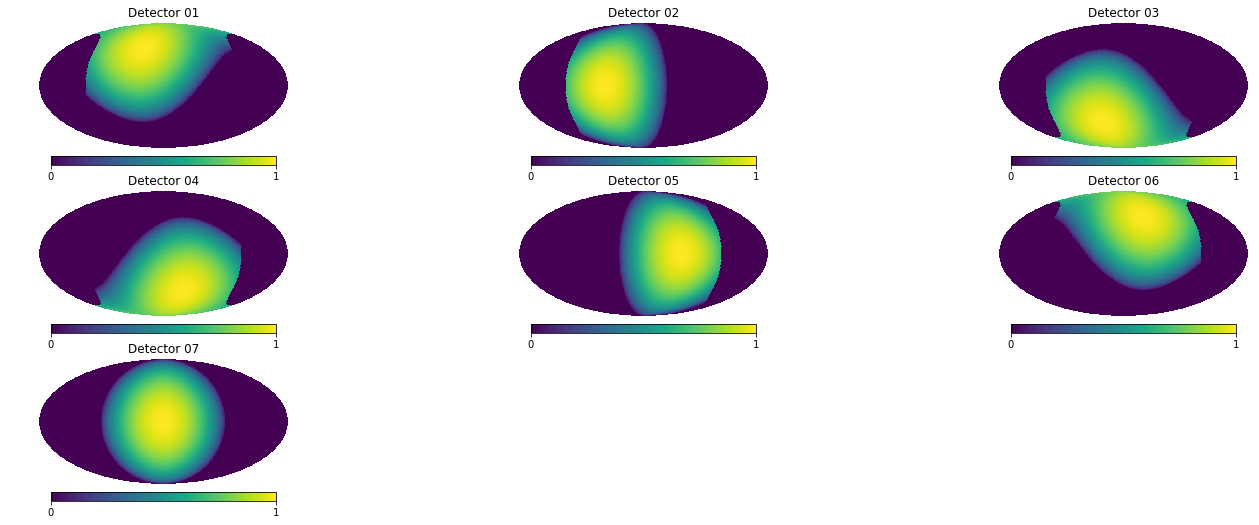

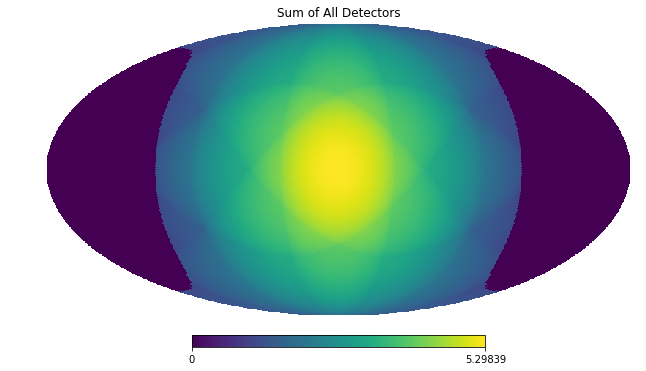

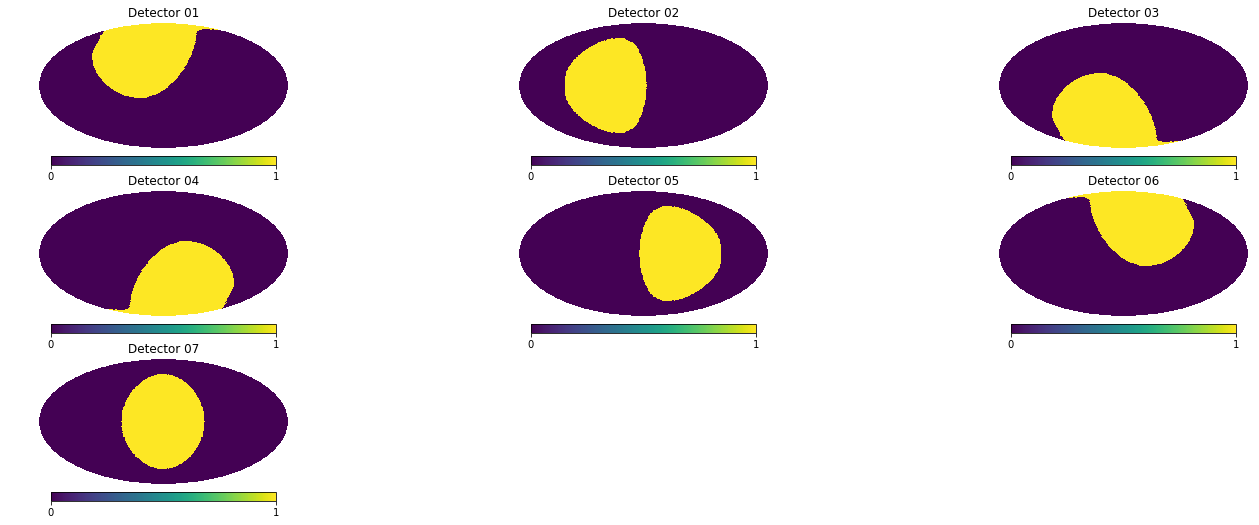

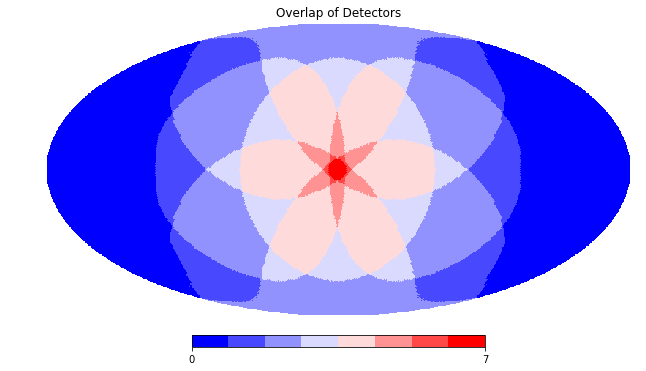

In [2]:
# setup Bia with 7 super detectors
pointings = {'01': ('30:0:0','55:0:0'),
               '02': ('90:0:0','55:0:0'),
                '03': ('150:0:0','55:0:0'),
               '04': ('210:0:0','55:0:0'),
               '05': ('270:0:0','55:0:0'),
               '06': ('330:0:0','55:0:0'),
               '07': ('0:0:0','0:0:0')}

index=0.6
Aeff=64.*4. # cm2
# sat2=True

sat2=False
lat='00:00:00'
lon='260:00:00'

## HAM
# pointings = {'01': ('60:00:00','70:00:00'),
#             '02': ('120:00:00','70:00:00'),
#             '03': ('180:00:00','70:00:00'),
#             '04': ('240:00:00','70:00:00'),
#             '05': ('300:00:00','70:00:00'),
#             '06': ('00:00:00','70:00:00'),
#             '07': ('00:00:00','00:00:00')}
# Aeff=128 #cm2
# index=0.78

## GBM
# pointings = {'01': ('45:54:0','20:36:0'),
#             '02': ('45:6:0','45:18:0'),
#             '03': ('58:24:0','90:12:0'),
#             '04': ('314:54:0','45:12:0'),
#             '05': ('303:12:0','90:18:0'),
#             '06': ('3:24:0','89:48:0'),
#             '07': ('224:54:0','20:24:0'),
#             '08': ('224:36:0','46:12:0'),
#             '09': ('236:36:0','90:0:0'),
#             '10': ('135:12:0','45:36:0'),
#             '11': ('123:42:0','90:24:0'),
#             '12': ('183:42:0','90:18:0')}
# Aeff=128
# index=0.78
# lat='50:00:00'
# lon='260:00:00'

##BurstCube
# pointings = {'01': ('0:0:0','45:0:0'),
#            '02': ('90:0:0','45:0:0'),
#            '03': ('180:0:0','45:0:0'),
#            '04': ('270:0:0','45:0:0')}
# Aeff=64.
# index=0.6

NSIDE=64  # resolution of healpix map (64 ~ 50k pixels)
Aeff_fact=1.#2.5
bia1,fs,exposure_positions,pointings,exposures=plot_exposures(pointings,Aeff_fact,index=index,NSIDE=NSIDE,lon=lon,lat=lat)#,Earth=False) 
fs_det=num_detectors(bia1,exposure_positions,pointings,NSIDE=NSIDE)
bia_exposures1=exposures+0.01 #add negligible amount to not crash with divide by 0
npointings=len(pointings)

### right now only looking at 1 spacecraft
##### bia 2
if sat2:
    bia2,fs,exposure_positions2,pointings,exposures=plot_exposures(pointings,Aeff_fact,index=index,lat='00:00:00',lon='80:00:00',NSIDE=NSIDE,Earth=False,antiEarth=True) 
    num_detectors(bia2,exposure_positions2,pointings,NSIDE=NSIDE)
    bia_exposures2=exposures+0.01

    npointings=len(pointings)*2

# combine exposures for both Bia spacecrafts
    biaexp=np.concatenate((bia_exposures1,bia_exposures2),axis=0)
else:
    biaexp=bia_exposures1
print np.max(biaexp)

In [3]:
### make lookup table
npix=len(bia_exposures1[0])
lookup=np.zeros([npointings,npix])

# fill in lookup table
for i in range(npix):
    for j in range(npointings):
        lookup[j,i]=biaexp[j,i]#/max(biaexp[:,i])
print np.shape(lookup)
print np.min(lookup),np.max(lookup)

(7, 49152)
0.01 1.0099999989611559


/Users/jracusin/anaconda/lib/python2.7/site-packages/matplotlib/projections/geo.py:426: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


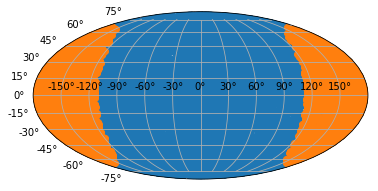

6993


In [4]:
### generate random points on the sky and their relative rates
n=10000
ra,dec=random_sky(n)
burst = np.array([[ detector.exposure(ra[i],dec[i], alt=-23.,index=index) for i in range(n)] for detector in bia1.detectors])
burst=burst+0.01#1.0

if sat2:
    burst1=burst
    burst2 = np.array([[ detector.exposure(ra[i],dec[i], alt=-90.,index=index) for i in range(n)] for detector in bia2.detectors])
    burst2=burst2+0.01
    burst=np.concatenate((burst1,burst2),axis=0)
# for i in range(n):
#     burst[:,i]=burst[:,i]/np.max(burst[:,i])

plot.figure()
plot.subplot(111, projection="mollweide")
msc=np.zeros(n)
msc[np.where(ra>180)[0]]=msc[np.where(ra>180)[0]]-360.

pm=plot.scatter(np.radians(ra+msc),np.radians(dec),marker='o')
#we=np.where(np.sum(burst,axis=0)==0.01*npointings)[0]
earthsep=separation(ra,dec,0.,0.)
we=np.where(earthsep>113.)[0]
plot.scatter(np.radians(ra[we]+msc[we]),np.radians(dec[we]),marker='o')
plot.grid(True)
plot.show()

## exclude bursts behind the Earth
#good=np.where(np.sum(burst,axis=0)>0.01*npointings)[0]
good=np.where(earthsep<=113.)[0]
print len(good)
burst=burst[:,good]
n=len(good)
ra=ra[good]
dec=dec[good]

In [5]:
sep=np.zeros(n)
err1sig=np.zeros(n)
minchisq=np.zeros(n)
snr=np.zeros(n)
#1 sec 50-300 keV peak flux ph/cm2/s
time = 1.0#0.064 # s
minflux=0.3
f=np.logspace(np.log10(minflux),2,50)
p=f**-1.05 # comes from fitting GBM sGRB logN-log peak flux
p=p/np.sum(p)
r=np.random.choice(f,p=p,size=n)
#src=1000.
bg=300.*Aeff/128.*time  # scaling from GBM average background rate
src=r*Aeff*time

## reality, detect count over some time in each detector
## have lookup tables for 3 spectral templates - exposure * integral(Aeff(E) * F(E), 50, 300)
## fit 3 lookup tables with counts, and choose best chisq


sig=np.array([0.68,0.95,0.997])
npar = 2 # number of parameters of interest (ra,dec)
delchisq=stats.chi2.ppf(sig,npar)
print delchisq

for k in range(n):  # loop over bursts
    rsrc=np.random.poisson(src[k],1) # randomly vary count rate within Poisson distribution
    s=rsrc*burst[:,k]+bg
#    s=src[k]*burst[:,k]+bg
    s.reshape((npointings,1))
    b=np.repeat(bg,npointings)
    b.reshape(npointings,1)
    snrs=(s-b)/np.sqrt(s)
    snr[k]=snrs[np.argsort(snrs)][-2] # second most on-axis detector significance
#     chisq=np.zeros(npix)
#     for i in range(npix):
#         m=lookup[:,i]
#         f=np.sum(m*(s-b)/s)/np.sum(m**2/s)
#         chisq[i]=np.sum((s-b-f*m)**2/(b+f*m))
    m=lookup#[:,i]
    f=np.sum(m*(s[:,None]-b[:,None])/s[:,None],axis=0)/np.sum(m**2/s[:,None],axis=0)
    chisq=np.sum((s[:,None]-b[:,None]-f*m)**2/(b[:,None]+f*m),axis=0)

    bestfit=np.argmin(chisq)#w[np.argmin(chisq[w])]
    minchisq[k]=chisq[bestfit]
    sep[k]=separation(exposure_positions[0,bestfit],exposure_positions[1,bestfit],ra[k],dec[k])
    w1sig=float(len(np.where((chisq>0) & (chisq<(np.min(chisq)+delchisq[0])))[0]))
#    w1sig=float(len(np.where((chisq>0) & (chisq<(np.min(chisq)+1.0)))[0]))
    err1sig[k]=np.sqrt(w1sig/npix*41253./np.pi)
    if err1sig[k]==0.: err1sig[k]=100.

[ 2.27886857  5.99146455 11.61828598]


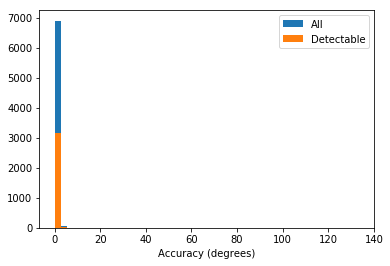

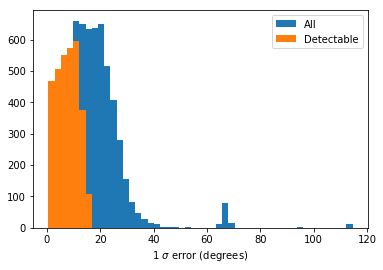

In [6]:
### which bursts are significant >4.5sigma in the 2nd brightest detector
wsig=np.where(snr>=4.5)[0]

h=plot.hist(sep,bins=np.linspace(np.min(sep),np.max(sep),50),label='All')
h=plot.hist(sep[wsig],bins=np.linspace(np.min(sep),np.max(sep),50),label='Detectable')
plot.xlabel('Accuracy (degrees)')
plot.legend()
plot.show()
h=plot.hist(err1sig,bins=np.linspace(np.min(err1sig),np.max(err1sig),50),label='All')
h=plot.hist(err1sig[wsig],bins=np.linspace(np.min(err1sig),np.max(err1sig),50),label='Detectable')
plot.xlabel(r'1 $\sigma$ error (degrees)')
plot.legend()
plot.show()


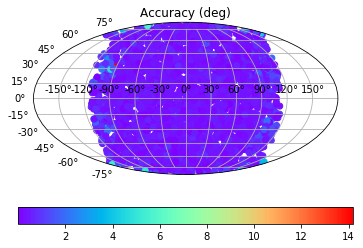

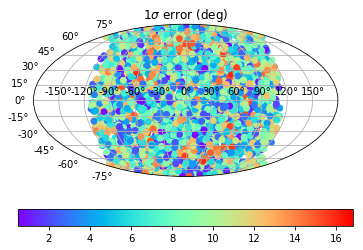

In [7]:
plot.figure()
plot.subplot(111, projection="mollweide")
msc=np.zeros(n)
msc[np.where(ra>180)[0]]=msc[np.where(ra>180)[0]]-360.
pm=plot.scatter(np.radians(ra[wsig]+msc[wsig]),np.radians(dec[wsig]),marker='o',c=sep[wsig],cmap=cm.rainbow)
plot.title('Accuracy (deg)')
plot.grid(True)
plot.colorbar(pm,orientation='horizontal')
plot.show()

plot.figure()
plot.subplot(111, projection="mollweide")
msc=np.zeros(n)
msc[np.where(ra>180)[0]]=msc[np.where(ra>180)[0]]-360.
pm=plot.scatter(np.radians(ra[wsig]+msc[wsig]),np.radians(dec[wsig]),marker='o',c=err1sig[wsig],cmap=cm.rainbow)
plot.title(r'1$\sigma$ error (deg)')
plot.grid(True)
plot.colorbar(pm,orientation='horizontal')
plot.show()

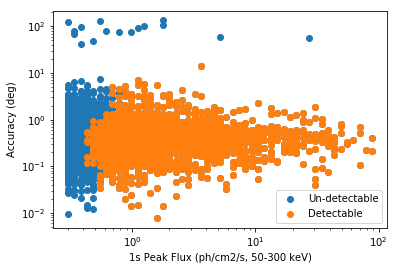

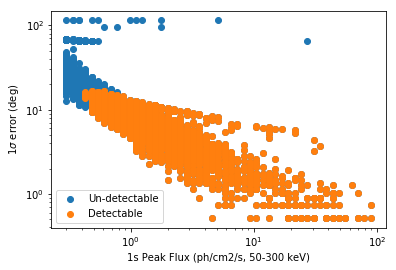

[0.         0.         0.01050788 0.07456979 0.44799054 0.77022654
 0.87748344 0.94354839 0.97742664 0.99444444 1.         1.
 0.98113208 1.         1.         1.         1.         1.
 1.         0.97297297 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.9375     1.         1.         1.         1.         1.
 1.         1.         1.        ]


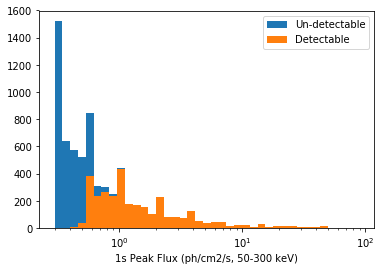

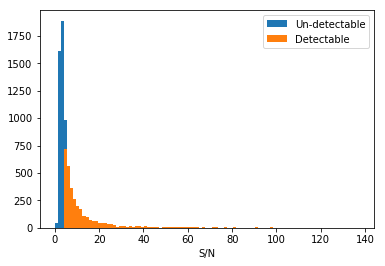

In [8]:
plot.plot(r,sep,marker='o',linestyle='None',label='Un-detectable')
plot.plot(r[wsig],sep[wsig],marker='o',linestyle='None',label='Detectable')
plot.xlabel('1s Peak Flux (ph/cm2/s, 50-300 keV)')
plot.ylabel('Accuracy (deg)')
plot.xscale('log')
plot.yscale('log')
plot.legend()
plot.show()

plot.plot(r,err1sig,marker='o',linestyle='None',label='Un-detectable')
plot.plot(r[wsig],err1sig[wsig],marker='o',linestyle='None',label='Detectable')
plot.xlabel('1s Peak Flux (ph/cm2/s, 50-300 keV)')
plot.ylabel(r'1$\sigma$ error (deg)')
plot.xscale('log')
plot.yscale('log')
plot.legend()
plot.show()

h1=plot.hist(r,bins=np.logspace(np.log10(np.min(r)),np.log10(np.max(r)),40),label='Un-detectable')
h2=plot.hist(r[wsig],bins=np.logspace(np.log10(np.min(r)),np.log10(np.max(r)),40),label='Detectable')
wh=np.where((h2[0]/h1[0])>=0.9)[0]
sens=h2[1][wh[0]]
print h2[0]/h1[0]
plot.xlabel('1s Peak Flux (ph/cm2/s, 50-300 keV)')
plot.xscale('log')
plot.legend()
plot.show()

plot.hist(snr,bins=np.linspace(np.min(snr),np.max(snr),100),label='Un-detectable')
plot.hist(snr[wsig],bins=np.linspace(np.min(snr),np.max(snr),100),label='Detectable')
plot.legend()
plot.xlabel('S/N')
plot.show()

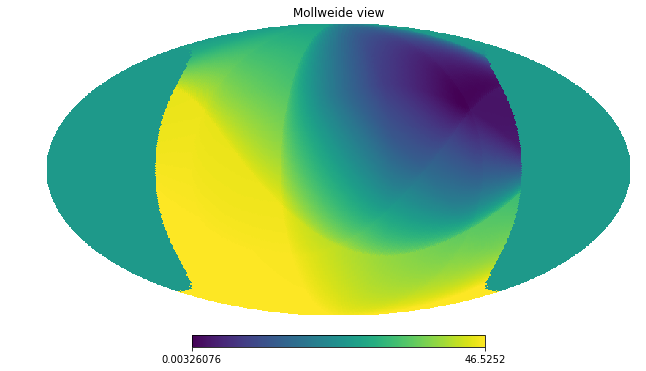

37.39018400465307
25.656805789439964
13.338879511070479
273.36958315137593 35.30113804049733 273.51562499999994 35.68533471265204 0.40217574843875575


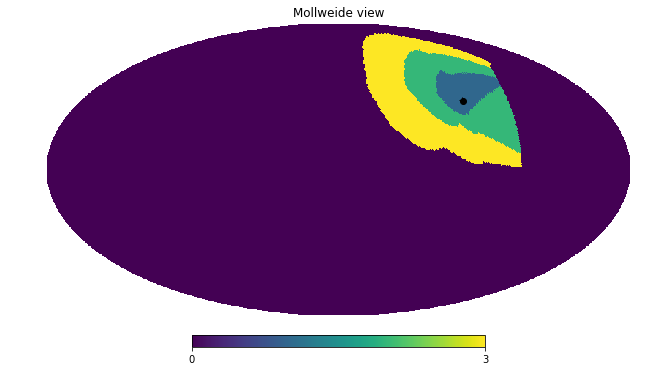

In [9]:
## Let's plot an example chisq map, and localization contour (using last burst in loop)

hp.mollview(chisq)
plot.show()

chisq_map = np.zeros(hp.nside2npix(NSIDE))
#chisq_map=np.vstack(hp.pix2ang(NSIDE, chisq_hp, lonlat=True))
w=np.where(chisq <(np.min(chisq)+delchisq[2]))[0]
print np.sqrt(float(len(w))/float(npix)*41253./np.pi)
chisq_map[w]=3
w=np.where(chisq <(np.min(chisq)+delchisq[1]))[0]
print np.sqrt(float(len(w))/float(npix)*41253./np.pi)
chisq_map[w]=2
w=np.where(chisq <(np.min(chisq)+delchisq[0]))[0]
print np.sqrt(float(len(w))/float(npix)*41253./np.pi)
chisq_map[w]=1
hp.mollview(chisq_map)
hp.projplot(ra[-1],dec[-1],marker='o',color='black',lonlat=True)
hp.projplot(exposure_positions[0,bestfit],exposure_positions[1,bestfit],marker='+',color='black',lonlat=True)
print ra[-1],dec[-1],exposure_positions[0,bestfit],exposure_positions[1,bestfit],sep[-1]
plot.show()

In [10]:
## What fraction of bursts have their accuracy better than their 1 sigma error?

print len(np.where(sep<err1sig)[0])
print n
print float(len(np.where(sep<err1sig)[0]))/n

6979
6993
0.997997997998


In [11]:
## check requirement that 80% with peak flux > 1 ph/cm2/s (50-300 keV) have 1sigerr<10 deg
n1=float(len(np.where(r[wsig]>=1.)[0]))
n2=float(len(np.where((r[wsig]>=1.) & (err1sig[wsig]<=10.))[0]))
print n2/n1

0.938695163105


In [12]:
print np.min(r[wsig])
print sens
print np.median(err1sig[wsig])
wb=np.where((r[wsig]>=1.))[0]# & (err1sig[wsig]<=10.))[0]
print np.median(err1sig[wsig[wb]])

0.4281374506439512
0.8331138047414028
7.68384104173514
4.765315921186425
